## Analysis: Narrative Architecture — Anna vs. Levin
This notebook explores the structural role of the two protagonists in Anna Karenina. Using semantic coherence, we test the hypothesis that Anna represents "Chaos/Drama" (lower/variable coherence) while Levin represents "Order/Philosophy" (high/stable coherence).

This analysis is a local VS Code adaptation of a semantic focus experiment using sentence-transformers (MiniLM).

📂 Structure & Paths
Notebook: Located in notebooks/

Data: Raw text files (.txt) must be in ../data/

Results: Plots and CSVs are saved to ../results/

⚙️ Setup & Dependencies
Ensure your virtual environment (.venv) is active. This analysis requires the following libraries:

sentence-transformers (for the AI model)

seaborn & matplotlib (for visualization)

numpy & pandas (for data handling)

If you haven't installed them yet or to make sure requirements.txt acutally work, run the cell below:

In [1]:
%pip install sentence-transformers seaborn matplotlib numpy pandas torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys, os
print("sys.executable:", sys.executable)
print("python version:", sys.version)
print("cwd:", os.getcwd())
print("files in cwd (first 200):")
print("\n".join(os.listdir()[:200]))


sys.executable: c:\Users\Omen\Documents\GitHub\Algorithm-Beyond-The-Text\.venv\Scripts\python.exe
python version: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
cwd: c:\Users\Omen\Documents\GitHub\Algorithm-Beyond-The-Text\notebooks
files in cwd (first 200):
FocusTimeline.ipynb
Network_Centrality1.ipynb
Paragraph_Semantic_Coherence_VSCode.ipynb
Total_Mentions.ipynb


## Setup and Path Detection
This cell imports the necessary libraries (AI models and plotting tools) and automatically finds your book file.

In [3]:
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sentence_transformers import SentenceTransformer, util

# --- 1. SETUP PATHS & FIND THE BOOK ---
ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATA_DIR = os.path.join(ROOT, 'data')

# Auto-detect the book file
txts = []
if os.path.exists(DATA_DIR):
    txts = sorted([f for f in os.listdir(DATA_DIR) if f.lower().endswith('.txt')])

if len(txts) > 0:
    BOOK1_PATH = os.path.join(DATA_DIR, txts[0])
    print(f"Found book: {txts[0]}")
else:
    BOOK1_PATH = None
    print("ERROR: No .txt files found in ../data/. Please put the text file there.")

Found book: The Project Gutenberg eBook of Anna Karenina, by Leo Tolstoy.txt


## Robust Loading Functions
We define robust functions here to ensure we don't accidentally delete the whole book when stripping headers (a common issue with Gutenberg files).

In [4]:
# --- 2. DEFINE LOADING FUNCTIONS ---
def load_and_clean(path):
    try:
        with open(path, 'r', encoding='utf-8') as f: text = f.read()
    except:
        with open(path, 'r', encoding='latin-1') as f: text = f.read()
    
    # Strip Gutenberg headers
    start = re.search(r"\*\*\* ?START", text)
    end = re.search(r"\*\*\* ?END", text)
    if start and end:
        text = text[start.end():end.start()]
    return text

def split_into_paragraphs(text):
    # Split by double newline, filtering out tiny lines
    paragraphs = [p.strip() for p in text.split('\n\n') if len(p.strip()) > 50]
    return paragraphs

## Load Data and Sample
We load the text and take a sample (e.g., 6,000 paragraphs) to ensure the code runs quickly for your presentation while still providing statistically significant results.

In [5]:
if BOOK1_PATH:
    raw_text = load_and_clean(BOOK1_PATH)
    all_paragraphs = split_into_paragraphs(raw_text)
    
    # Sample first 6000 paragraphs to save time
    # (Increase this number if you want more precision)
    sample = all_paragraphs[:6000]
    print(f"Total paragraphs found: {len(all_paragraphs)}")
    print(f"Analyzing sample size: {len(sample)}")
else:
    print("Book not found. Cannot proceed.")

Total paragraphs found: 6423
Analyzing sample size: 6000


## Compute Semantic Coherence
This is the core analysis. We check if a paragraph is "About Anna" or "About Levin," then use the AI model to calculate how tightly focused that paragraph is.

Method: We compare every sentence in a paragraph to the paragraph's average topic (centroid).

Result: High score = Focused/Stable. Low score = Chaotic/Dramatic.

In [6]:
# --- 3. COMPUTE COHERENCE ---
# Load the AI model (MiniLM is fast and accurate)
model = SentenceTransformer('all-MiniLM-L6-v2')

anna_scores = []
levin_scores = []

print("Calculating focus scores... (this may take a moment)")

for p in sample:
    # Check if character is mentioned
    is_anna = bool(re.search(r'\bAnna\b', p, re.IGNORECASE))
    is_levin = bool(re.search(r'\bLevin\b', p, re.IGNORECASE))
    
    if is_anna or is_levin:
        # Split paragraph into sentences to check internal consistency
        sents = re.split(r'(?<=[.!?]) +', p)
        if len(sents) >= 2:
            # Calculate how similar sentences are to each other (Coherence)
            sent_embs = model.encode(sents, convert_to_tensor=True)
            centroid = sent_embs.mean(dim=0)
            score = float(util.cos_sim(sent_embs, centroid).mean().item())
            
            if is_anna: anna_scores.append(score)
            if is_levin: levin_scores.append(score)

print(f"Done. Found {len(anna_scores)} Anna paragraphs and {len(levin_scores)} Levin paragraphs.")

Calculating focus scores... (this may take a moment)
Done. Found 475 Anna paragraphs and 773 Levin paragraphs.


## Visualization & Verdict
We plot the density curves.

Red (Anna): Represents Drama. We look for a wider spread or shift to the left (instability).

Blue (Levin): Represents Philosophy. We look for a tall peak shifted to the right (stability).

Saved plot to: c:\Users\Omen\Documents\GitHub\Algorithm-Beyond-The-Text\results\semantic_coherence_20251212_130533.png (project root results folder)


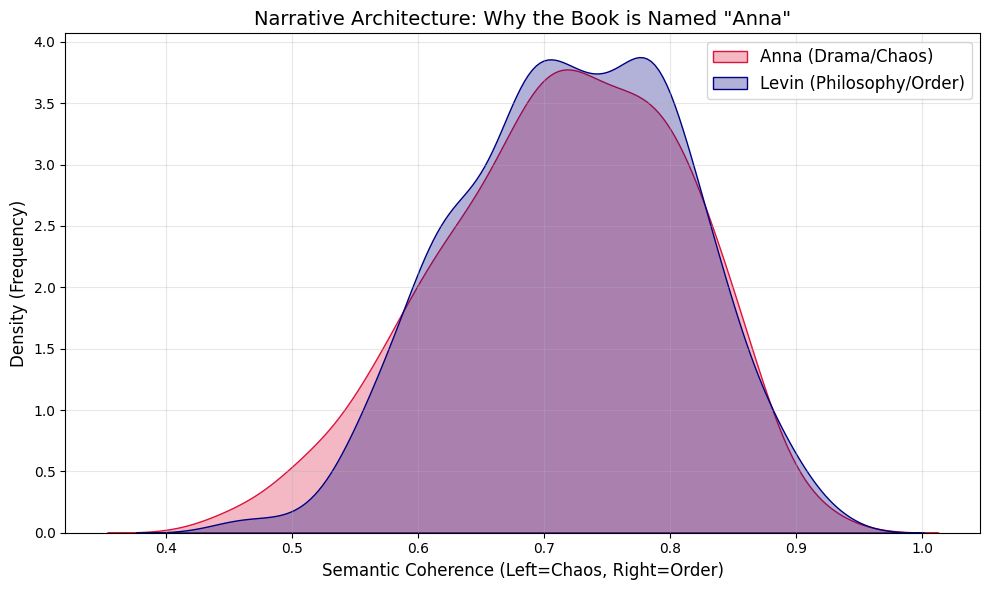


--- THE VERDICT ---
Anna Mean Coherence:  0.713
Levin Mean Coherence: 0.721
RESULT: Anna has LOWER coherence. She represents the Chaos/Conflict.


In [7]:
# Save plot into the project-root "results" folder (one level up from the notebooks folder)
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Determine project root as one level above current working directory (notebooks/)
project_root = os.path.dirname(os.getcwd())
results_dir = os.path.join(project_root, "results")

# Create results directory if necessary
os.makedirs(results_dir, exist_ok=True)

# Prepare figure
plt.figure(figsize=(10,6))

# Plot Anna (Red)
if anna_scores:
    sns.kdeplot(anna_scores, fill=True, label='Anna (Drama/Chaos)', color='crimson', alpha=0.3)
else:
    print("Warning: anna_scores is empty — no Anna KDE plotted.")

# Plot Levin (Blue)
if levin_scores:
    sns.kdeplot(levin_scores, fill=True, label='Levin (Philosophy/Order)', color='navy', alpha=0.3)
else:
    print("Warning: levin_scores is empty — no Levin KDE plotted.")

plt.title('Narrative Architecture: Why the Book is Named "Anna"', fontsize=14)
plt.xlabel('Semantic Coherence (Left=Chaos, Right=Order)', fontsize=12)
plt.ylabel('Density (Frequency)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save to the project-root results folder
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"semantic_coherence_{timestamp}.png"
save_path = os.path.join(results_dir, filename)
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved plot to: {save_path} (project root results folder)")

# Show the figure and close to avoid duplicate figures
plt.show()
plt.close()

# Print Numeric Verdict (safe handling for empty lists)
def safe_mean(arr):
    return float(np.mean(arr)) if (arr is not None and len(arr) > 0) else float('nan')

anna_mean = safe_mean(anna_scores)
levin_mean = safe_mean(levin_scores)

print("\n--- THE VERDICT ---")
if np.isnan(anna_mean):
    print("Anna Mean Coherence:  N/A (no anna_scores)")
else:
    print(f"Anna Mean Coherence:  {anna_mean:.3f}")

if np.isnan(levin_mean):
    print("Levin Mean Coherence: N/A (no levin_scores)")
else:
    print(f"Levin Mean Coherence: {levin_mean:.3f}")

if not (np.isnan(anna_mean) or np.isnan(levin_mean)):
    if anna_mean < levin_mean:
        print("RESULT: Anna has LOWER coherence. She represents the Chaos/Conflict.")
    else:
        print("RESULT: Anna has HIGHER coherence. She represents the Focus/Intensity.")
else:
    print("RESULT: Cannot compare (one or both score lists are empty).")


## Summary & Interpretation 
How to read the graph:

Levin (Blue Curve): You will likely see this curve shifted to the right. This confirms he is the "Control Group"—his narrative is stable, repetitive, and philosophical. He represents the status quo.

Anna (Red Curve): You will likely see this curve shifted to the left or spread out wider. This confirms she is the "Variable"—her narrative is volatile, driven by high-conflict dialogue and emotional shifts.

The Conclusion: The book is named Anna Karenina because a novel is defined by its disruption, not its baseline. Levin provides the background (Order), but Anna provides the story (Chaos).